Matrícula: 	564307\
Nível: 	MESTRADO\
Status: 	ATIVO\
E-Mail: 	danieloliveirafff@gmail.com\
Entrada: 	2024.1\
Orientador: 	JOAO PAULO DO VALE MADEIRO\
Área: 	CIÊNCIA DA COMPUTAÇÃO\
Linha de Pesquisa: 	TEORIA DA COMPUTAÇÃO

# **Biblioteca**

In [ ]:
# Tratamentos de dados
import pandas as pd
import numpy as np

# Métricas
from sklearn.metrics import davies_bouldin_score # esta biblioteca calcula metrica a partir do índice DB (Davies-Bouldin).

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# carregando os dados
# motando o google drive

from google.colab import drive
drive.mount('/content/drive')

link = '/content/drive/MyDrive/UFC_mestrado/Sigaa_UFC/1_semestre/aprendizagem_automatica/lista_06_ama/dados/quake.csv'

#link = '/content/quake.csv'



df = pd.read_csv(link, header=None)

dados = np.array(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Tratamento dos dados**

In [ ]:
np.random.seed(420) # para manter aleatoriedade

In [ ]:
df.head()

,0,1
0,-52.26,28.30
1,45.53,150.93
2,41.85,142.78
3,29.19,141.15
4,-21.66,169.81


In [ ]:
# Embaralhar os índices
indices = np.random.permutation(len(dados))

# Usar esses índices para embaralhar os dados
X_embaralhado = dados[indices]

# Determinar o tamanho dos conjuntos de treino e teste (80% treino, 20% teste)
tamanho_treino = int(len(X_embaralhado) * 0.8)  # Treino (80%)
tamanho_teste = len(X_embaralhado) - tamanho_treino  # Teste (20%)

# Dividir os dados em treino e teste
xtreino = X_embaralhado[:tamanho_treino]
xteste = X_embaralhado[tamanho_treino:]

# Exibir os tamanhos dos conjuntos de treino e teste
print(f"Tamanho treino: {xtreino.shape}")
print(f"Tamanho teste: {xteste.shape}")

Tamanho treino: (1742, 2)
Tamanho teste: (436, 2)


In [ ]:
normalizacao = lambda x : (x - np.mean(x, axis = 0)) / np.std(x, axis = 0) # normalização  StandardScaler()

# normalizando o x_treino
x_norm_treino = normalizacao(xtreino)

# normalizando o x_teste
x_norm_teste = normalizacao(xteste)

# **Gráficos**

In [ ]:
def grafico_linha(dados,best_k,centroides_finais, modelo):
    # Plotar o agrupamento para o melhor valor de k
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='longitude', y='latitude', hue='cluster', palette='viridis', data=dados, legend="full")

    # Adicionar os centróides ao gráfico
    plt.scatter(
        centroides_finais[:, 1],  # Longitude dos centróides
        centroides_finais[:, 0],  # Latitude dos centróides
        s=150,                   # Tamanho dos centróides
        c='red',                 # Cor dos centróides
        marker='o',              # Formato do marcador dos centróides
        label='Centroides',      # Nome na legenda
        edgecolor='black'        # Cor da borda dos centróides
    )

    # Adicionar título e legendas
    plt.title(f'Modelo {modelo} Melhor Agrupamento K-médias (k={best_k})')
    plt.legend(
        loc='best',              # Localização automática da legenda
        bbox_to_anchor=(1.17, 1),# Posicionar a legenda à direita do gráfico
        title='Clusters',
        borderaxespad=0          # Ajusta o padding da borda
    )
    plt.show()


# **Modelo K-médias**

Este modelo está sendo usado como função que permite calcular atráves da
distancia euclediana ou mahalanobis.

In [ ]:
# Função para calcular a distância euclidiana
def calcular_euclediana(lista1, lista2):
    quadrado = 0  # Inicializa a variável para armazenar a soma dos quadrados das diferenças
    for x, y in zip(lista1, lista2):  # Itera sobre os elementos das duas listas simultaneamente
        diferenca = x - y  # Calcula a diferença entre os elementos das listas
        quadrado += diferenca ** 2  # Eleva a diferença ao quadrado e adiciona à soma dos quadrados
    return np.sqrt(quadrado)  # Retorna a distância euclidiana calculada

# Função para calcular a distância Mahalanobis
def calcular_mahalanobis(lista1, lista2, covariance_matrix):
    diferenca = lista1 - lista2  # Calcula a diferença entre os elementos das listas
    inversa_covariance_matrix = np.linalg.inv(covariance_matrix)  # Calcula a inversa da matriz de covariância
    distancia = np.sqrt(np.dot(np.dot(diferenca.T, inversa_covariance_matrix), diferenca))  # Calcula a distância de Mahalanobis
    return distancia  # Retorna a distância de Mahalanobis calculada

# Função para inicializar os centróides aleatoriamente
def inicializar_centroides(X, k):
    # Seleciona k pontos aleatórios do conjunto de dados como centróides iniciais
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroides = X[indices]
    return centroides

# Função para atribuir pontos de dados ao centróide mais próximo
def atribuir_cluster(X, centroides, escolha, covariance_matrix=None):
    clusters = []
    for ponto in X:
        if escolha == 'Euclidiana':  # Escolher distância euclidiana
            distancias = [calcular_euclediana(ponto, centroide) for centroide in centroides]
        elif escolha == 'Mahalanobis' and covariance_matrix is not None:  # Escolher distância Mahalanobis
            distancias = [calcular_mahalanobis(ponto, centroide, covariance_matrix) for centroide in centroides]
        else:
            raise ValueError("Escolha inválida ou matriz de covariância não fornecida para Mahalanobis.")
        cluster_mais_proximo = np.argmin(distancias)  # Encontra o centróide mais próximo
        clusters.append(cluster_mais_proximo)
    return np.array(clusters)

# Função para atualizar a posição dos centróides com base nos pontos atribuídos
def atualizar_centroides(X, clusters, k):
    novo_centroides = []
    for i in range(k):
        # Calcula a média dos pontos atribuídos ao cluster i
        pontos_do_cluster = X[clusters == i]
        if len(pontos_do_cluster) > 0:
            novo_centroide = np.mean(pontos_do_cluster, axis=0)
        else:
            novo_centroide = np.zeros(X.shape[1])  # Caso um cluster fique vazio, evita erro
        novo_centroides.append(novo_centroide)
    return np.array(novo_centroides)

# Algoritmo K-means
def k_means(X, k, max_iter=200, escolha='Euclidiana'):
    covariance_matrix = None
    if escolha == 'Mahalanobis':
        covariance_matrix = np.cov(X, rowvar=False)  # Calcula a matriz de covariância se a distância for Mahalanobis
    centroides = inicializar_centroides(X, k)  # Inicializa os centróides
    for _ in range(max_iter):
        clusters = atribuir_cluster(X, centroides, escolha, covariance_matrix)  # Atribui os pontos aos clusters
        novos_centroides = atualizar_centroides(X, clusters, k)  # Recalcula os centróides

        # Verifica convergência (se os centróides não mudaram significativamente)
        if np.allclose(centroides, novos_centroides):
            break

        centroides = novos_centroides

    return centroides, clusters

# **Treinando o modelo K-means com a distância Euclidiana**

In [ ]:
best_k = None
best_db_score = np.inf
best_kmeans = None

for k in range(4, 21):
    db_scores = []

    # k_means retorna os centróides e os clusters finais
    centroides_finais, clusters_finais = k_means(xtreino, k, escolha='Euclidiana')

    # Criando um DataFrame
    df_02 = pd.DataFrame(xtreino, columns=['latitude', 'longitude'])
    df_02['cluster'] = clusters_finais  # Atribuir os clusters finais gerados pelo K-means

    # Calcular o índice de Davies-Bouldin
    db_score = davies_bouldin_score(xtreino, clusters_finais)
    db_scores.append(db_score)

    # SSelecionar a melhor execução com base no menor erro  Davies-Bouldin
    avg_db_score = np.mean(db_scores)
    if avg_db_score < best_db_score:
        best_db_score = avg_db_score
        best_k = k
        best_kmeans = (centroides_finais, clusters_finais)



centroides_finais, clusters_finais = best_kmeans

# Exibir o melhor valor de k e o respectivo índice DB
print(f"Melhor valor de k: {best_k}")
print(f"Melhor índice Davies-Bouldin: {best_db_score}")


Melhor valor de k: 7
Melhor índice Davies-Bouldin: 0.5306297421670043


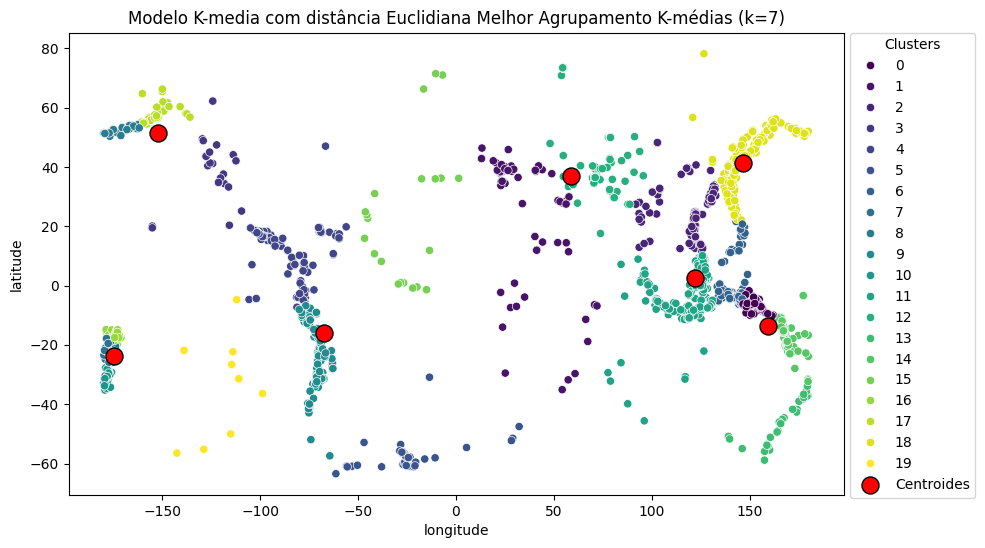

In [ ]:
grafico_linha(df_02 , best_k, centroides_finais, 'K-media com distância Euclidiana')

# **Treinando o modelo K-means com a distância Mahalanobis**

In [ ]:
best_k = None
best_db_score = np.inf
best_kmeans = None

for k in range(4,21):
    db_scores = []

    # k_means retorna os centróides e os clusters finais
    centroides_finais, clusters_finais = k_means(xtreino, k, escolha='Mahalanobis')

    # Criando um DataFrame
    df_03 = pd.DataFrame(xtreino, columns=['latitude', 'longitude'])
    df_03['cluster'] = clusters_finais  # Atribuir os clusters finais gerados pelo K-means

    # Calcular o índice de Davies-Bouldin
    db_score = davies_bouldin_score(xtreino, clusters_finais)
    db_scores.append(db_score)

    # Selecionar a melhor execução com base no menor erro  Davies-Bouldin
    avg_db_score = np.mean(db_scores)
    if avg_db_score < best_db_score:
        best_db_score = avg_db_score
        best_k = k
        best_kmeans = (centroides_finais, clusters_finais)

centroides_finais, clusters_finais = best_kmeans
# 4. Exibir o melhor valor de k e o respectivo índice DB
print(f"Melhor valor de k: {best_k}")
print(f"Melhor índice Davies-Bouldin: {best_db_score}")



Melhor valor de k: 9
Melhor índice Davies-Bouldin: 0.8338648765040578


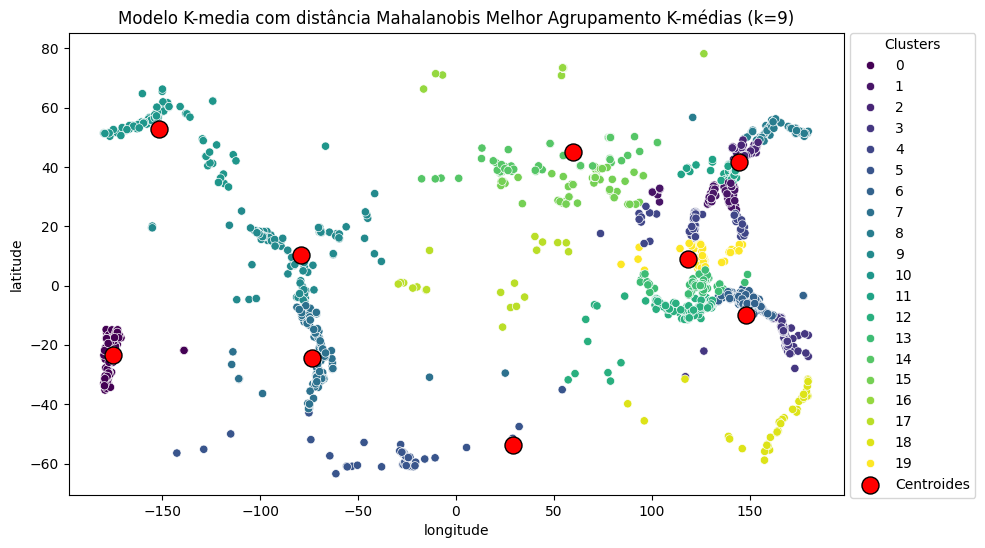

In [ ]:
grafico_linha(df_03 , best_k, centroides_finais, 'K-media com distância Mahalanobis')

Modelo PCA

In [ ]:
# carregando os dados
# motando o google drive
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

link = '/content/drive/MyDrive/UFC_mestrado/Sigaa_UFC/1_semestre/aprendizagem_automatica/lista_06_ama/dados/penguins.csv'

#link = '/content/penguins.csv'

dados_questao_02 = pd.read_csv(link, header=None)

dados_questao_02 = np.array(dados_questao_02)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# separando os dados de x e de y


np.random.seed(420) # para manter aleatoriedade

# Separar os atributos (X) e a saída (y)
X = dados_questao_02[:, :-1]
y = dados_questao_02[:, -1]
y = np.array(y).reshape(-1, 1)



# Gerar um array de índices embaralhados
indices = np.random.permutation(len(X))

# Usar esses índices para embaralhar X e y de forma consistente
X_embaralhado = X[indices]
y_embaralhado = y[indices]




# limitando a quantidade de linha para treino, teste e validação do x_normalizado e y_binarios
# Dividir os dados em treino (80%),e teste (20%)

tamanho_treino = int(len(X_embaralhado) * 0.8)  # Treino (80%)
tamanho_teste = X_embaralhado.shape[0] - tamanho_treino # Teste (20%)


# # Dividir os dados em treino,  teste
xtreino = X_embaralhado[:tamanho_treino]
ytreino = y_embaralhado[:tamanho_treino].flatten() # convertando o y em unidimensional


xteste = X_embaralhado[tamanho_treino:]
yteste = y_embaralhado[tamanho_treino:].flatten() # convertando o y em unidimensional


In [ ]:

normalizacao = lambda x : (x - np.mean(x, axis = 0)) / np.std(x, axis = 0) # normalização  StandardScaler()

# normalizando o x_treino
x_norm_treino = normalizacao(xtreino)

# normalizando o x_teste
x_norm_teste = normalizacao(xteste)


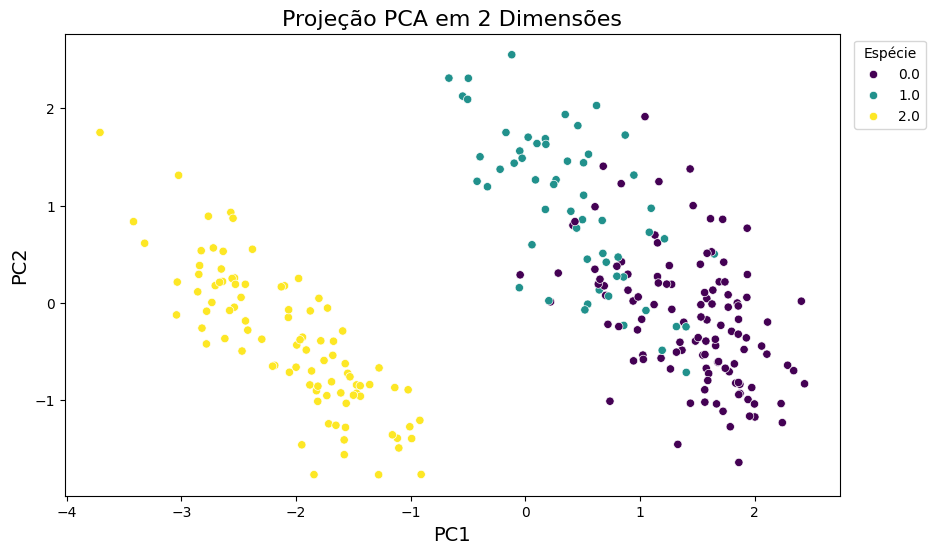

Variância explicada com 1 componentes: 0.6867
Variância explicada com 2 componentes: 0.8811
Variância explicada com 3 componentes: 0.9737
Variância explicada com 4 componentes: 1.0000


In [ ]:

# Centralizar os dados (subtrair a média)
X_media = np.mean(x_norm_treino, axis=0)
X_centrado = x_norm_treino - X_media

# Calcular a matriz de covariância
matriz_covariancia = np.cov(X_centrado, rowvar=False)

# Decompor a matriz de covariância em autovalores e autovetores
autovalores, autovetores = np.linalg.eig(matriz_covariancia)

# Ordenar autovalores e autovetores em ordem decrescente
indices_ordenados = np.argsort(autovalores)[::-1]
autovalores_ordenados = autovalores[indices_ordenados]
autovetores_ordenados = autovetores[:, indices_ordenados]

# Projeção dos dados nas duas primeiras componentes principais
n_componentes = 2  # Projeção em 2 dimensões
W = autovetores_ordenados[:, :n_componentes]  # Escolher os 2 autovetores principais
X_pca = np.dot(X_centrado, W)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['espécie'] = ytreino

# Plotar os dados projetados em 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='espécie', palette='viridis', data=df_pca, legend='full')

plt.title('Projeção PCA em 2 Dimensões', fontsize=16)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.legend(
    title='Espécie',
    loc='best',              # Localização automática da legenda
    bbox_to_anchor=(1.12, 1) # Posicionar a legenda à direita do gráfico
)
plt.show()

# Calcular a variância explicada para cada número de componentes principais
variancia_explicada = autovalores_ordenados / np.sum(autovalores_ordenados)

# Mostrar a variância explicada com 1, 2, 3 e 4 componentes
for i in range(1, 5):
    print(f"Variância explicada com {i} componentes: {np.sum(variancia_explicada[:i]):.4f}")
